In [13]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from itertools import combinations, product
import math
import numpy as np
from tqdm import tqdm

In [14]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Arial'

In [15]:
def getFrequencies(cts, sq, n):
    """
    Get frequencies of n-nucleotides from a set of sequences
    
    cts:      A list or a pd.Series of read counts
    sq:       A list or a pd.Seiries of sequences
    n:        Get frequencies of n-nucleotides
    returns:  A pandas dataframe
    """

    nts = [''.join(x) for x in list(product('ATGC', repeat=n))]
    pos = list(combinations([x for x in range(0, len(sq.iloc[0]))], r=n))
    counts = {x:[0 for y in range(0, len(pos))] for x in nts}

    for c, s in tqdm(zip(cts, sq)):
        for i, p in enumerate(pos):
            try:
                b = ''.join([s[b] for b in p])
                counts[b][i] += c
            except:
                pass
    df_counts = pd.DataFrame(counts, index=pd.MultiIndex.from_tuples(pos, names=(['p' + str(x) for x in range(1, n + 1)])))
    df_fq = df_counts / sum(cts)
    return df_fq

In [16]:
def getMI_p(df_snfqx, df_dnfqx):
    """
    Get pairwise mutual information matrix from single and di-nucleotide frequencies
    
    df_snfx:      single nucleotide frequencies dataframe
    df_dnfx:      di nucleotide frequencies dataframe
    returns:      A pandas dataframe of mutual information values
    """

    mi_di = []

    for index, row in df_dnfqx.iterrows():

        p1, p2 = index[0], index[1]
        v_p1, v_p2 = df_snfqx.loc[(p1,)], df_snfqx.loc[(p2,)]

        s_exp = pd.Series({dn : df_snfqx.loc[(index[0],), dn[0]] * df_snfqx.loc[(index[1],), dn[1]] for dn in df_dnfqx.columns})
        s_obs = row

        res = sum([s_obs[x] * math.log((s_obs[x] / s_exp[x])) for x in df_dnfqx.columns if s_obs[x] != 0])
        mi_di.append((p1, p2, res))

    df_mi_di = pd.DataFrame(mi_di)
    df_mi_di.columns=['p1', 'p2', 'mi']
    df_mi_di = df_mi_di.sort_values('mi', ascending=False)
    return df_mi_di

In [17]:
# Read dataset
df = pd.read_csv('/home/kurfurst/Documents/datasets/MV_aurora_reselection.tsv', sep='\t', names=['count', 'seq'])

In [18]:
# Compute single nucleotide frequencies
df_snfq = getFrequencies(df['count'], df['seq'], 1)
# Compute double nucleotide frequencies
df_dnfq = getFrequencies(df['count'], df['seq'], 2)

849535it [00:24, 34627.73it/s]
849535it [24:15, 583.68it/s]


In [19]:
# Compute Mutual Information values

mi = getMI_p(df_snfq, df_dnfq)

In [20]:
# Pivot and renumber labels to be 1-based

df_mi = mi.pivot(columns='p2', index='p1', values='mi')
df_mi.columns = [x + 1 for x in df_mi.columns]
df_mi.index = [x + 1 for x in df_mi.index]

In [21]:
# Create a dictionary translating full-length numbering to core numbering

aurora_core_positions = [1,2,3,4,5,6,7,8,9,10,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]
aurora_core_names = [x for x in range(1, len(aurora_core_positions) + 1)]
dct_aurora_core = {x:y for x, y in zip(aurora_core_positions, aurora_core_names)}

In [22]:
# Select core positions

df_mi = df_mi.loc[[x for x in aurora_core_positions if x in df_mi.index]]
df_mi = df_mi[[x for x in aurora_core_positions if x in df_mi.columns][::-1]]

In [23]:
# Rename labels to represent core numbering

df_mi.index = [dct_aurora_core[x] for x in df_mi.index]
df_mi.columns = [dct_aurora_core[x] for x in df_mi.columns]

In [24]:
# Making a mask
mask = np.zeros_like(df_mi)
mask[np.triu_indices_from(mask)] = True
mask = np.flip(mask, 0)

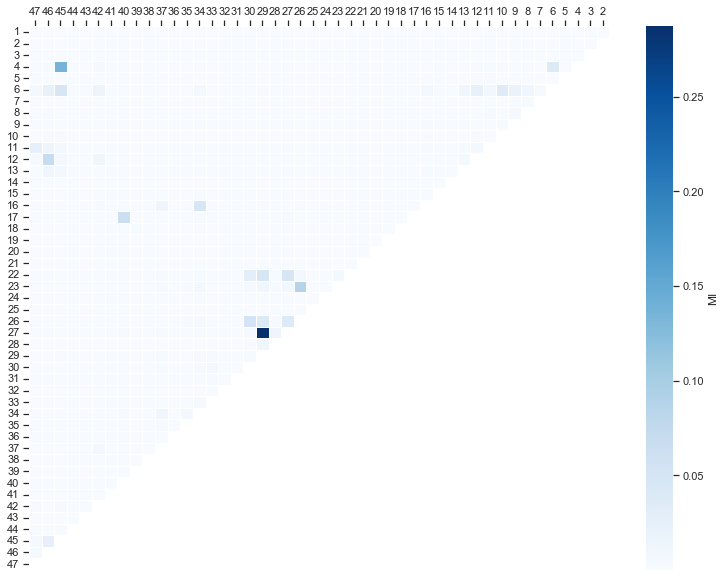

In [27]:
sns.set(rc={"figure.figsize":(13, 10)})
sns.set_style('white')
ax = sns.heatmap(df_mi, linewidths=.7, mask=mask, linecolor='white', cmap='Blues', cbar_kws={'label': 'MI'})
ax.xaxis.tick_top()
ax.yaxis.tick_left()
plt.savefig('fig3b.png', dpi=180)

In [28]:
df_mi.to_csv('fig3b.tsv', sep='\t')